In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import concat, read_csv, DataFrame
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
class PreProcessing:

    @staticmethod
    def normalize(x):
        scaler = StandardScaler()
        return scaler.fit_transform(x), scaler

    @staticmethod
    def apply_pca(x, n_components=None):
        pca = PCA(n_components=n_components)
        x_pca = pca.fit_transform(x)
        explained_variance = pca.explained_variance_ratio_
        print(f"Explained variance by each component: {explained_variance}")
        print(f"Total explained variance: {sum(explained_variance)}")
        return x_pca, pca

    @staticmethod
    def drop_na_columns(data):
        return data.dropna(axis=1, how='all')

    @staticmethod
    def convert_to_categorical(data):
        label_encoders = {}
        for column in data.select_dtypes(include=['int', 'object']):
            le = LabelEncoder()
            data[column] = le.fit_transform(data[column])
            label_encoders[column] = le
        return data, label_encoders

    @staticmethod
    def impute_missing_values(data):
        imputer = SimpleImputer(strategy='mean')
        imputer.fit(data)
        return imputer.transform(data)

    @staticmethod
    def resample_data(x, y):
        smote = SMOTE()
        return smote.fit_resample(x, y)

In [3]:
class EvaluationMetrics:

    @staticmethod
    def silhouette_score(x, labels):
        if len(set(labels)) > 1:  # Ensure at least 2 clusters exist
            score = silhouette_score(x, labels)
        else:
            score = -1  # Invalid score if only one cluster exists
        return score

    @staticmethod
    def calinski_harabasz_score(x, labels):
        if len(set(labels)) > 1:  # Ensure at least 2 clusters exist
            score = calinski_harabasz_score(x, labels)
        else:
            score = -1  # Invalid score if only one cluster exists
        return score

    @staticmethod
    def davies_bouldin_score(x, labels):
        if len(set(labels)) > 1:  # Ensure at least 2 clusters exist
            score = davies_bouldin_score(x, labels)
        else:
            score = -1  # Invalid score if only one cluster exists
        return score

    @staticmethod
    def plot_clusters(x, labels, title):
        plt.figure(figsize=(8, 6))
        plt.scatter(x[:, 0], x[:, 1], c=labels, cmap='Pastel1', edgecolor='k', s=50)
        plt.title(f'Cluster Plot - {title}')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(label='Cluster Label')
        plt.show()

    @staticmethod
    def elbow_method(x, max_clusters=10):
        distortions = []
        for i in range(1, max_clusters + 1):
            kmeans = KMeans(n_clusters=i)
            kmeans.fit(x)
            distortions.append(kmeans.inertia_)
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, max_clusters + 1), distortions, marker='o')
        plt.title('Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('Distortion')
        plt.grid()
        plt.show()
        return distortions

Explained variance by each component: [0.29015079 0.0868979 ]
Total explained variance: 0.3770486938867826


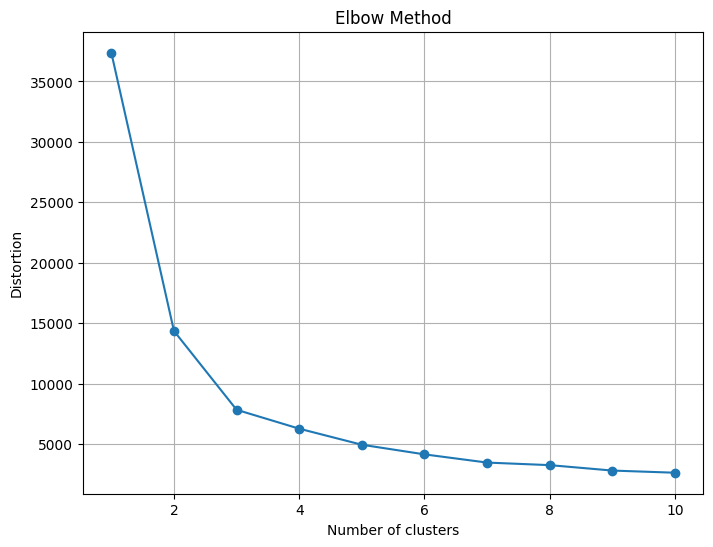


KMeans Model with k=5:


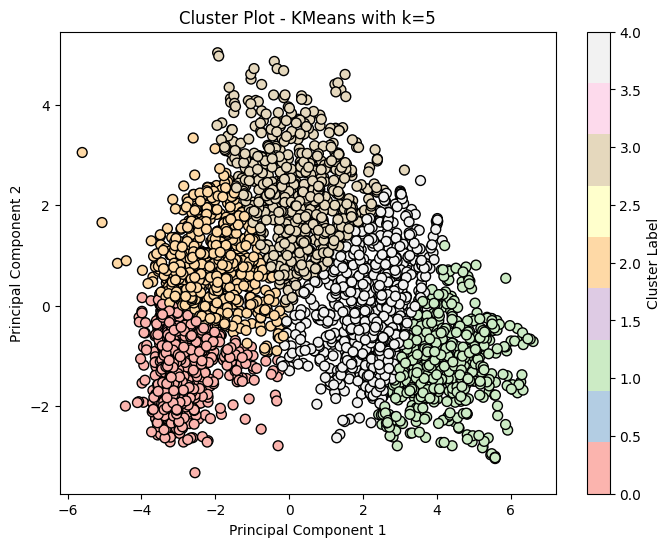


DBSCAN Model:
Number of clusters: 2
Silhouette Score: 0.12083439035649
Calinski-Harabasz Score: 9.994036867831966
Davies-Bouldin Score: 2.251155560843355


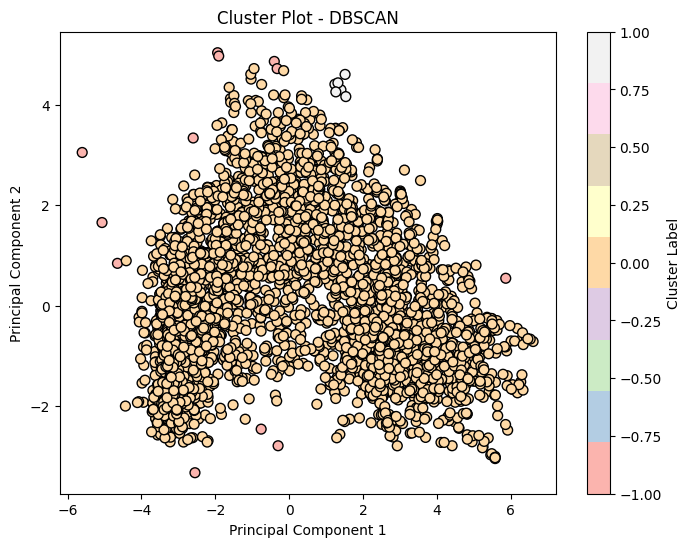


Agglomerative Model:
Number of clusters: 5
Silhouette Score: 0.3636820813744121
Calinski-Harabasz Score: 5218.151735712734
Davies-Bouldin Score: 0.9504366251608882


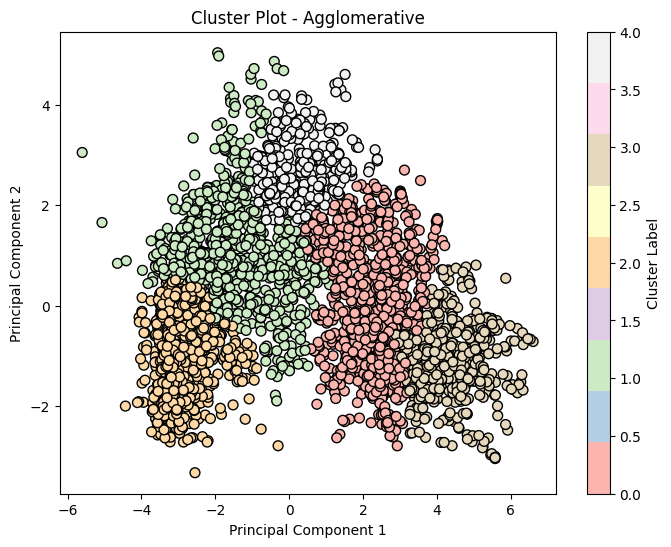


Spectral Model:
Number of clusters: 5
Silhouette Score: 0.38086250968660296
Calinski-Harabasz Score: 5675.409470726028
Davies-Bouldin Score: 0.8372621698679185


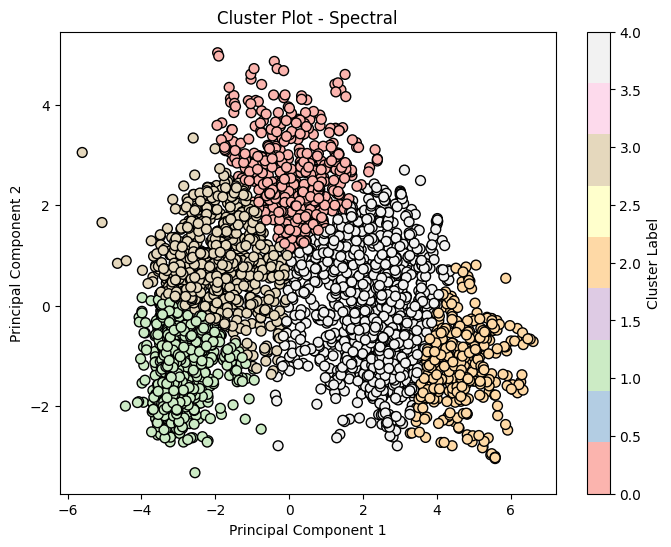


Best Model based on Silhouette Score: KMeans with a score of 0.3944681392823111


In [4]:
def main() -> None:
    # Load the data from the CSV file
    df = read_csv("/content/drive/MyDrive/Dataset/marketing_campaign.csv",sep = "\t")

    # Drop columns with all NaN values
    df = PreProcessing.drop_na_columns(df)

    # Convert integer and object columns to categorical values
    df, label_encoders = PreProcessing.convert_to_categorical(df)

    # Assuming the target column is named 'target'; change it as per your dataset
    target_column = 'Response'  # Update this to your actual target column name

    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in the dataset.")

    # Select target variable and feature variables
    y = df[target_column]
    x = df.drop(target_column, axis=1)

    # Impute missing values
    x = PreProcessing.impute_missing_values(x)

    # Resample using SMOTE
    x, y = PreProcessing.resample_data(x, y)

    # Standardize the data
    x, scaler = PreProcessing.normalize(x)

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    # Apply PCA
    x_pca, pca = PreProcessing.apply_pca(x, n_components=2)

    # Perform elbow method to find optimal k
    distortions = EvaluationMetrics.elbow_method(x_pca, max_clusters=10)

    # # Prompt the user for optimal k or choose based on the elbow
    # optimal_k = int(input("Enter the optimal number of clusters (k) based on the elbow method: "))
    optimal_k = 5
    # Train KMeans with the optimal k
    kmeans = KMeans(n_clusters=optimal_k)
    kmeans_labels = kmeans.fit_predict(x_pca)

    # Store evaluation metrics
    best_model_scores = {
        'KMeans': {
            'Silhouette': EvaluationMetrics.silhouette_score(x_pca, kmeans_labels),
            'Calinski-Harabasz': EvaluationMetrics.calinski_harabasz_score(x_pca, kmeans_labels),
            'Davies-Bouldin': EvaluationMetrics.davies_bouldin_score(x_pca, kmeans_labels)
        }
    }

    print(f'\nKMeans Model with k={optimal_k}:')
    EvaluationMetrics.plot_clusters(x_pca, kmeans_labels, f'KMeans with k={optimal_k}')

    # Train other clustering models and store their scores
    models = {
        'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
        'Agglomerative': AgglomerativeClustering(n_clusters=optimal_k),
        'Spectral': SpectralClustering(n_clusters=optimal_k)
    }

    for name, model in models.items():
        labels = model.fit_predict(x_pca)
        print(f'\n{name} Model:')

        # Print number of clusters found
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f'Number of clusters: {num_clusters}')

        score_silhouette = EvaluationMetrics.silhouette_score(x_pca, labels)
        score_calinski = EvaluationMetrics.calinski_harabasz_score(x_pca, labels)
        score_davies = EvaluationMetrics.davies_bouldin_score(x_pca, labels)

        # Store evaluation metrics for the model
        best_model_scores[name] = {
            'Silhouette': score_silhouette,
            'Calinski-Harabasz': score_calinski,
            'Davies-Bouldin': score_davies
        }

        # Print evaluation metrics
        print(f'Silhouette Score: {score_silhouette}')
        print(f'Calinski-Harabasz Score: {score_calinski}')
        print(f'Davies-Bouldin Score: {score_davies}')

        EvaluationMetrics.plot_clusters(x_pca, labels, name)

    # Determine the best model based on evaluation metrics
    best_model = None
    best_score = -np.inf  # Initialize for maximization

    # Finding the model with the best silhouette score
    for model_name, scores in best_model_scores.items():
        if scores['Silhouette'] > best_score:
            best_model = model_name
            best_score = scores['Silhouette']

    # Print the best model
    print(f"\nBest Model based on Silhouette Score: {best_model} with a score of {best_score}")

    return None

if __name__ == '__main__':
    main()